#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [2]:
!which python

Der Befehl "which" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


# Install dependencies:

In [3]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

# Imports

In [4]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
#import umap
import umap.umap_ as umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [5]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [7]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [8]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [9]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [10]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.7734578
n_clusters: 102 silhouette_avg: 0.3168553
n_clusters: 202 silhouette_avg: 0.31620553
n_clusters: 302 silhouette_avg: 0.2914882
n_clusters: 402 silhouette_avg: 0.2596832
n_clusters: 502 silhouette_avg: 0.22168234


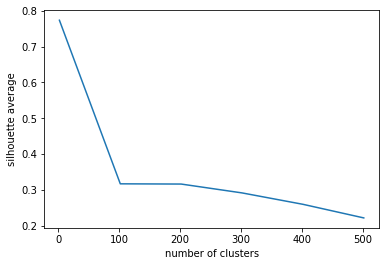

In [11]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=600 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [67]:
number_of_clusters =  20
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 0     12
6     18
9     19
17    23
19    25
14    26
11    27
8     29
16    29
13    32
10    34
7     38
5     40
3     46
15    48
2     50
18    51
12    56
1     68
4     98
Name: label_kmedoids, dtype: int64


In [68]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [69]:
num_dimensions = 2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

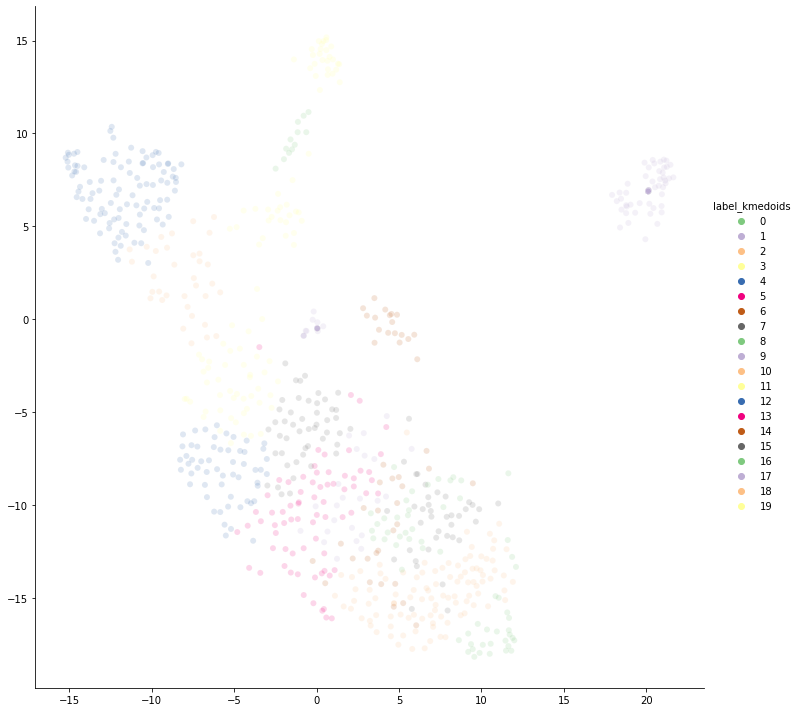

In [70]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  
            hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

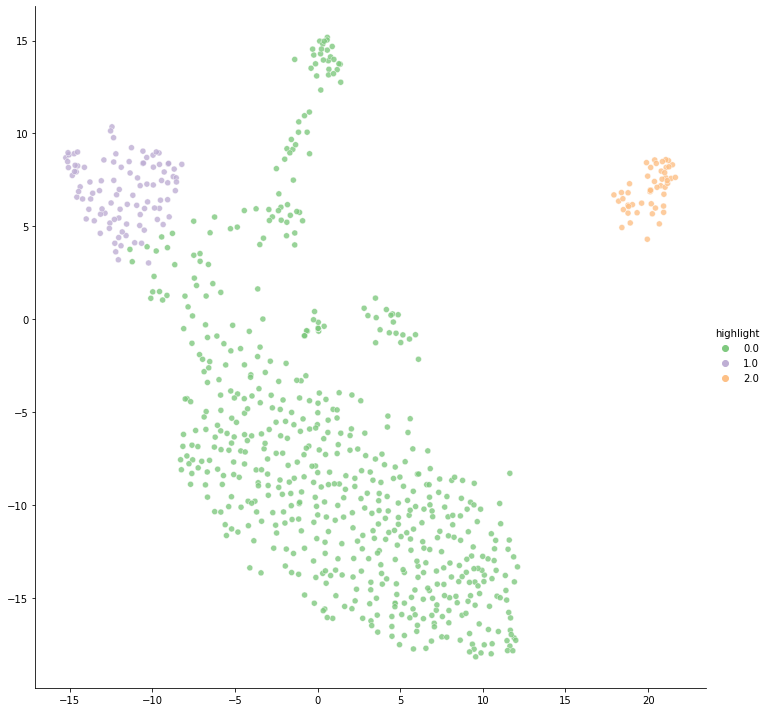

In [95]:
## Choose a cluster to higlight:
cluster_num = 4
cluster_num1 = 1

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight']  = 1
data.loc[data['label_kmedoids'] == cluster_num1, 'highlight'] = 2

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [72]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight,highlight2
594,2020-10-28 17:49:25,Sensibelchen,"@Jonas An was für Detail hängst Du Dich jetzt wieder auf? Ich dachte Du wolltest Dich mal richtig informieren? Was haben nun die Mitglieder des Fachbeitrats damit zu tun? Warum haben alle im Vorstand des IPCC, die den Berichts zusammenstellen einen politischen Hintergrund? Für Dich ist also einseitig der Überbringer einer Nachricht wichtiger als die Nachricht selbst. Alles Klar, Du woltest nur trollen. Deine ""Aussage"", daß Du nur die Aussagen im Video nachvollziehen willst, war also nur Geschwafel und keine ernst gemeinte Aussage.",1,"@ An was für Detail hängst Du Dich jetzt wieder auf? Ich dachte Du\nwolltest Dich mal richtig informieren? Was haben nun die Mitglieder des\nFachbeitrats damit zu tun? Warum haben alle im Vorstand des IPCC, die den\nBerichts zusammenstellen einen politischen Hintergrund? Für Dich ist also\neinseitig der Überbringer einer Nachricht wichtiger als die Nachricht selbst.\nAlles Klar, Du woltest nur trollen. Deine ""Aussage"", daß Du nur die Aussagen\nim Video nachvollziehen willst, war also nur Geschwafel und keine ernst\ngemeinte Aussage.\n\n",-1,0,0.000000e+00,0.0,0.0
187,2020-11-08 13:58:45,Androlan01,https://jottesgedanken.wordpress.com/2020/01/15/wie-leugnen-luegen-funktioniert-schoenwiese/,1,\nfunktioniert-schoenwiese/\n\n,die dummen anderen,1,5.960464e-08,0.0,0.0
646,2020-10-27 16:50:19,Bernd Wellmann,Recht haben Sie.!,1,Recht haben Sie.!\n\n,-1,2,2.384186e-07,0.0,0.0
319,2020-10-27 20:50:24,Fab Tel,"Es geht einfach um unsere Kohle. Ganz große Lobbyarbeit, mehr nicht! Wir sollen konsumieren, unter dem Deckmantel des Umweltschutzes, dabei bedeutet Nachhaltigkeit in erster Linie so lange Nutzen wie es nur geht.",0,"Es geht einfach um unsere Kohle. Ganz große Lobbyarbeit, mehr nicht! Wir\nsollen konsumieren, unter dem Deckmantel des Umweltschutzes, dabei bedeutet\nNachhaltigkeit in erster Linie so lange Nutzen wie es nur geht.\n\n",-1,3,5.960464e-08,0.0,0.0
706,2020-10-28 12:14:50,Tannenherz Bushcraft,Beinahe die einzige Partei mit der nötigen Kompetenz und die Partei mit der größten Kompetenz. Freundlichst Fiete,1,Beinahe die einzige Partei mit der nötigen Kompetenz und die Partei mit der\ngrößten Kompetenz. Freundlichst Fiete\n\n,-1,4,5.960464e-08,0.0,0.0
282,2020-10-28 03:17:33,Bernd Groner,Super erklärt! 1 setzen und für die Ungebildeten bitte den Mund halten oder nach der Sitzung hüpfen.,0,Super erklärt! 1 setzen und für die Ungebildeten bitte den Mund halten oder\nnach der Sitzung hüpfen.\n\n,-1,5,0.000000e+00,0.0,0.0
353,2020-10-27 19:14:13,Old Zeppelin,"Hallo Herr Dr. Christian Blex , bitte zeigen Sie die Quellen an ,denn die Brauch ich unbedingt . Danke Danke Danke.",0,"Hallo Herr Dr. Christian Blex , bitte zeigen Sie die Quellen an ,denn die\nBrauch ich unbedingt . Danke Danke Danke.\n\n",-1,6,3.576279e-07,0.0,0.0
512,2020-10-27 15:47:37,TheHirade,Die wurden schön vorgeführt 👍,0,Die wurden schön vorgeführt 👍\n\n,die dummen anderen,7,0.000000e+00,0.0,0.0
453,2020-10-27 16:26:52,Dirk Spelsberg,Wann wird das Volk endlich wach 😡,0,Wann wird das Volk endlich wach 😡\n\n,-1,8,0.000000e+00,0.0,0.0
150,2020-10-29 15:30:23,Roland Welsch,Klasse er verwendet eine Grafik von 1995. Aber die letzten 25 Jahre ist die Temperatur weiter gestiegen. Mit einer Grafik von 2020 würde man sehen das es jetzt wärmer ist als die letzten 10.000 Jahre. Hat er das mit Absicht gemacht????,0,Klasse er verwendet eine Grafik von 1995. Aber die letzten 25 Jahre ist die\nTemperatur weiter gestiegen. Mit einer Grafik von 2020 würde man sehen das es\njetzt wärmer ist als die letzten 10.000 Jahre. Hat er das mit Absicht\ngemacht????\n\n,-1,9,0.000000e+00,0.0,0.0


In [73]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  12 mean distance from center:  0.0007236997134896228 Proportion of replies: 91.66666666666667
1 number of samples:  68 mean distance from center:  0.0011229340088902973 Proportion of replies: 61.76470588235294
2 number of samples:  50 mean distance from center:  0.0021792649931740016 Proportion of replies: 68.0
3 number of samples:  46 mean distance from center:  0.0039011240005493164 Proportion of replies: 54.34782608695652
4 number of samples:  98 mean distance from center:  0.003736238068086095 Proportion of replies: 27.551020408163264
5 number of samples:  40 mean distance from center:  0.004141479803365655 Proportion of replies: 42.5
6 number of samples:  18 mean distance from center:  0.0009655952453613281 Proportion of replies: 5.555555555555555
7 number of samples:  38 mean distance from center:  0.003866145561914891 Proportion of replies: 39.473684210526315
8 number of samples:  29 mean distance from center:  0.0029627619369421154 Proportion of replies: 6

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [74]:
# Choose a cluster to print
cluster_number =   21
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 0
Average Distance from cluster center: nan


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight,highlight2


# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [96]:
#which cluster would you like to assign labels to?
cluster_number = 1
#your label
label_manual = 'Fakten'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 0.1

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [97]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight,highlight2
511,2020-11-08 13:56:43,Androlan01,https://jottesgedanken.wordpress.com/2020/01/15/wie-leugnen-luegen-funktioniert-schoenwiese/,1,\nfunktioniert-schoenwiese/\n\n,Fakten,1,5.960464e-08,2.0,0.0
515,2020-11-08 13:49:59,Androlan01,https://jottesgedanken.wordpress.com/2020/01/15/wie-leugnen-luegen-funktioniert-schoenwiese/,1,\nfunktioniert-schoenwiese/\n\n,Fakten,1,5.960464e-08,2.0,0.0
519,2020-11-08 13:58:13,Androlan01,https://jottesgedanken.wordpress.com/2020/01/15/wie-leugnen-luegen-funktioniert-schoenwiese/,1,\nfunktioniert-schoenwiese/\n\n,Fakten,1,5.960464e-08,2.0,0.0
402,2020-11-08 13:46:56,Androlan01,https://jottesgedanken.wordpress.com/2020/01/15/wie-leugnen-luegen-funktioniert-schoenwiese/,1,\nfunktioniert-schoenwiese/\n\n,Fakten,1,5.960464e-08,2.0,0.0
413,2020-11-08 13:53:44,Androlan01,https://jottesgedanken.wordpress.com/2020/01/15/wie-leugnen-luegen-funktioniert-schoenwiese/,1,\nfunktioniert-schoenwiese/\n\n,Fakten,1,5.960464e-08,2.0,0.0
424,2020-11-08 13:59:31,Androlan01,https://jottesgedanken.wordpress.com/2020/01/15/wie-leugnen-luegen-funktioniert-schoenwiese/,1,\nfunktioniert-schoenwiese/\n\n,Fakten,1,5.960464e-08,2.0,0.0
531,2020-11-08 13:56:30,Androlan01,https://jottesgedanken.wordpress.com/2020/01/15/wie-leugnen-luegen-funktioniert-schoenwiese/,1,\nfunktioniert-schoenwiese/\n\n,Fakten,1,5.960464e-08,2.0,0.0
430,2020-11-08 13:56:24,Androlan01,https://jottesgedanken.wordpress.com/2020/01/15/wie-leugnen-luegen-funktioniert-schoenwiese/,1,\nfunktioniert-schoenwiese/\n\n,Fakten,1,5.960464e-08,2.0,0.0
432,2020-11-08 13:58:57,Androlan01,https://jottesgedanken.wordpress.com/2020/01/15/wie-leugnen-luegen-funktioniert-schoenwiese/,1,\nfunktioniert-schoenwiese/\n\n,Fakten,1,5.960464e-08,2.0,0.0
187,2020-11-08 13:58:45,Androlan01,https://jottesgedanken.wordpress.com/2020/01/15/wie-leugnen-luegen-funktioniert-schoenwiese/,1,\nfunktioniert-schoenwiese/\n\n,Fakten,1,5.960464e-08,2.0,0.0
